### Product Quality Assessment :
#### Classifying Products to Defected VS Not Defected (OK) based on their front image .
* **Dataset** : Kaggle Dataset : https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product
* **Data** : The data contains 7348 grayscale images for a manufacturing product, 300x300 pixel images , augmentation results included

## Project Methodology :

- Business Understanding:  What is the Business Objective ?
    * The objective is to detect whether a manufactured product is defected or not  
- Use Case:
    * The production company wants to eliminate the defected products so the ones classifid as defected will not be sent to shipping .
    
- Understanding our ML Pipeline:
       * Input : 300 by 300 grayscale images with 1 color layer
       * output : Classes of the Images , 0 as defected and 1 as Safe or OK
- Framing the Problem :
     * The problem here is an Image Classification task using a CNN
- Designing the System
     * The Value of the output is 0 or 1 So the goal is to predict labels for images "Ok_front"  and "def_front'
     * We will be having a Binary classification Task


In [9]:
# Installs
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.2 MB/s eta 0:00:00


In [10]:
# Necessary imports
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
import tensorflow_model_optimization as tfmot

from sklearn.metrics import confusion_matrix, classification_report , roc_curve, auc


import matplotlib.pyplot as plt
import pickle
import zipfile
from google.colab import drive
import os



In [11]:
!gdown "1H37RrO0OiLv0wk4MskK6VCtZ_iatMxLe"

Downloading...
From: https://drive.google.com/uc?id=1H37RrO0OiLv0wk4MskK6VCtZ_iatMxLe
To: /content/Impellers.zip
100% 70.9M/70.9M [00:01<00:00, 59.2MB/s]


In [12]:
# Set the paths to the dataset file and the extraction path
dataset_file_path = '/content/Impellers.zip'
extraction_path = '/content/'

In [13]:
  os.makedirs(extraction_path, exist_ok=True)
  # Extract the zipped dataset
  with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)

In [ ]:
# Define function to load the dataset from Google Drive
def load_from_drive(dataset_file_path,extraction_path):
  """
  Load a dataset from Google Drive, extract it to the specified path.

  Parameters:
  - dataset_file_path (str): The path to the zipped dataset file on Google Drive.
  - extraction_path (str): The path where the dataset should be extracted.

  Returns:
  None
  """
  # Mount Google Drive to access the dataset file
  drive.mount('/content/drive')
  # Create the extraction directory if it doesn't exist
  os.makedirs(extraction_path, exist_ok=True)
  # Extract the zipped dataset
  with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)

In [6]:
# Set the paths to the dataset file and the extraction path
dataset_file_path = '/content/drive/My Drive/Impellers.zip'
extraction_path = '/content/'

In [ ]:
# Load dataset to colab runtime
load_from_drive(dataset_file_path,extraction_path)

In [14]:
# Define the path to the training and validation directory
data_dir ='/content/dataset'
# Define the path to test directory

test_dir = "/content/test_dataset/"

In [15]:
# Set datagenerator parameters
# Set target size for images
image_size = (300, 300)

# Set batch_size for tf dataset
batch_size = 32
# Set the seed for random operations.
seed = 42

In [16]:

# Create tf generators
def create_data_generators(data_dir, test_dir, image_size, batch_size=32, seed=42):
    """
    Creates and configures data generators for training, validation, and testing using Keras' ImageDataGenerator.

    Parameters:
    - data_dir (str): Path to the directory containing training and validation data.
    - test_dir (str): Path to the directory containing test data.
    - image_size (tuple): Target size for input images in the format (height, width).
    - batch_size (int, optional): Number of samples per batch. Defaults to 32.
    - seed (int, optional): Seed for reproducibility. Defaults to 42.

    Returns:
    - train_generator (DirectoryIterator): Generator for training data.
    - validation_generator (DirectoryIterator): Generator for validation data.
    - test_generator (DirectoryIterator): Generator for test data.
    """
    # Train and validation datagen
    datagen = ImageDataGenerator(
        validation_split=0.3,
        rescale=1.0 / 255.0
    )

    # Test datagen
    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0
    )

    # Train generator
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=seed
    )

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=True,
        seed=seed
    )

    # Test generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        class_mode='binary',
        shuffle=False,
        seed=seed
    )

    return train_generator, validation_generator, test_generator




In [17]:
# Create data generators for training, validation, and testing
train_generator, validation_generator, test_generator = create_data_generators(data_dir, test_dir, image_size, batch_size, seed)


Found 4786 images belonging to 2 classes.
Found 2050 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


In [18]:
# Get size of train, validation and test samples
num_train_samples = train_generator.n
num_val_samples = validation_generator.n
num_test_samples = test_generator.n

In [19]:

# Define function to create dataset from generator

def create_dataset_from_generator(generator, image_size):
    """
    Create a TensorFlow dataset from a generator function.

    Parameters:
    - generator (generator): A generator function that yields tuples of images and labels.
    - image_size (tuple): The size of the input images in the format (height, width).

    Returns:
    - tf.data.Dataset: A TensorFlow dataset containing image-label pairs.
    """
    # Define the output signature for the dataset based on image size and data types
    # Create a TensorFlow dataset from the generator with the specified output signature

    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )

In [20]:
# Create tf datasets from generators
train_dataset = create_dataset_from_generator(train_generator, image_size)
validation_dataset = create_dataset_from_generator(validation_generator, image_size)
test_dataset = create_dataset_from_generator(test_generator, image_size)

In [21]:
# View datasets properties
print('Train Dataset',train_dataset)
print('Validation Dataset:',validation_dataset)

Train Dataset <_FlatMapDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Validation Dataset: <_FlatMapDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [22]:
# Extract classes
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(train_generator.class_indices.keys())
print(class_names)

{'def_front': 0, 'ok_front': 1}
['def_front', 'ok_front']


In [23]:
# Define functions to assert images are grayscale or not

def is_grayscale(image):
    """
    Check if an image is grayscale.

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array.

    Returns:
    - bool: True if the image is grayscale, False otherwise.
    """
    return image.shape[-1] == 1


def assert_grayscale(dataset, dataset_name):
    """
    Assert that all images in a dataset are grayscale.

    Parameters:
    - dataset (tf.data.Dataset): The input dataset containing image-label pairs.
    - dataset_name (str): The name of the dataset used for error messages.

    Returns:
    - bool: True if all images are grayscale, False otherwise.
    """
    for image, label in dataset:
        # Check if each image in the dataset is grayscale
        if not is_grayscale(image):
            print(f"Error: {dataset_name} contains non-grayscale images.")
            return False

    # If no non-grayscale images are found, print a success message
    print(f"All images in {dataset_name} are grayscale.")
    return True


In [ ]:
# Check if images in datasets are grayscale (height,width,1)
assert_grayscale(train_dataset, "train_dataset")
assert_grayscale(validation_dataset, "validation_dataset")

In [24]:
# Set visualization style for matplotlib plots
plt.style.use('default')

In [25]:

# Create function to visualize images from a TensorFlow dataset

def visualize_dataset(dataset, class_names, num_images):
    """
    Visualize a batch of images from a TensorFlow dataset.

    Parameters:
    - dataset (tf.data.Dataset): The input dataset containing image-label pairs.
    - class_names (list): List of class names corresponding to the labels.
    - num_images (int): Number of images to visualize.

    Returns:
    - None: Displays the visualized images using Matplotlib.
    """
    # Extract a batch of images from the dataset
    batch = next(iter(dataset))
    images, labels = batch  # Extract images and labels from the batch

    # Set figure size
    plt.figure(figsize=(15, 10))

    # Iterate through the specified number of images
    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(1, num_images, i + 1)

        # Display the image
        plt.imshow(images[i])
        # Set the title as the corresponding class name
        plt.title(class_names[int(labels[i])])

        # Remove axes for better visualization
        plt.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the visualized images
    plt.show()


Train_dataset:


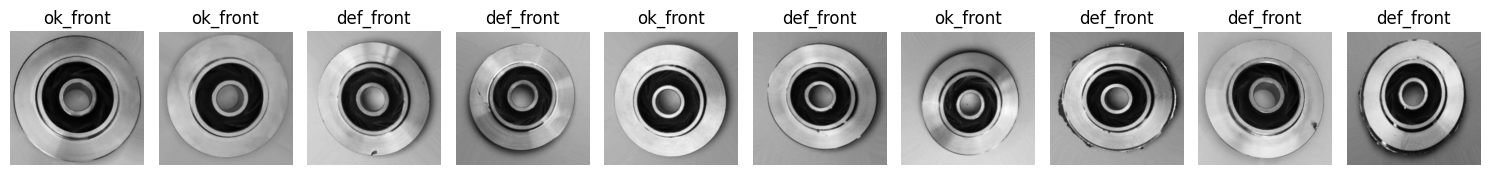

validation_dataset:


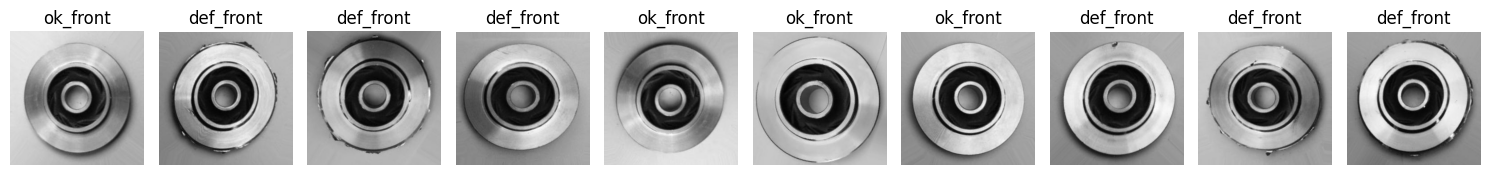

In [26]:
# Visualize k original images
print('Train_dataset:')
visualize_dataset(train_dataset, class_names, num_images=10)
print('validation_dataset:')
visualize_dataset(validation_dataset, class_names, num_images=10)

In [27]:
# Create function to convert rgb images to grayscale using tf
def convert_to_grayscale(image, label=None):
    grayscale_image = tf.image.rgb_to_grayscale(image)

    return grayscale_image, label

In [28]:
# Convert to grayscale
grayscale_train_data = train_dataset.map(convert_to_grayscale)
grayscale_validation_data = validation_dataset.map(convert_to_grayscale)
grayscale_test_data = test_dataset.map(convert_to_grayscale)

In [29]:
# View final datasets properties
print('Train Dataset',grayscale_train_data)
print('Validation Dataset:',grayscale_validation_data)

Train Dataset <_MapDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Validation Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [30]:
# Set input image properties for CNN Model
num_color_layers =1
img_shape = image_size +(num_color_layers,)
print('Image Shape:',img_shape)

Image Shape: (300, 300, 1)


In [31]:


# Build CNN model

def build_cnn_model(img_shape, num_color_layers):
    """
    Build a Convolutional Neural Network (CNN) model using TensorFlow's Sequential API.

    Parameters:
    - img_shape (tuple): The shape of the input images in the format (height, width, channels).
    - num_color_layers (int): The dilation rate for Conv2D layers.

    Returns:
    - tf.keras.Sequential: The constructed CNN model.
    """
    # Convolutional Neural Network Sequential Model
    model = tf.keras.Sequential([
        # Input layer with the specified input image shape
        tf.keras.layers.Input(shape=img_shape),

        # Conv2D layer with 16 filters, a 3 x 3 kernel size, and a relu activation
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), dilation_rate=num_color_layers, padding='same', activation='relu'),
        # Downsampling to reduce the spatial dimensions of the input while retaining important features
        tf.keras.layers.MaxPooling2D(),

        # Conv2D layer with 32 filters, a 3 x 3 kernel size, and a relu activation
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), dilation_rate=num_color_layers, padding='same', activation='relu'),
        # Default downsampling
        tf.keras.layers.MaxPooling2D(),

        # Conv2D layer with 64 filters, a 3 x 3 kernel size, and a relu activation
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), dilation_rate=num_color_layers, padding='same', activation='relu'),
        # Default downsampling
        tf.keras.layers.MaxPooling2D(),

        # Flatten feature map into a 1D vector
        tf.keras.layers.Flatten(),

        # Fully connected network layer with 128 neurons and a relu activation
        tf.keras.layers.Dense(128, activation='relu'),

        # Output layer of the fully connected network with 1 neuron representing a binary output (sigmoid function)
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model


In [32]:
# Build CNN model
model = build_cnn_model(img_shape, num_color_layers)


In [33]:
# View cnn summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

In [ ]:
# Clear previous models from memory before training a new model
# del model
# tf.keras.backend.clear_session()

In [35]:
# Compile model using adam ,binary cross entropy and accuracy as a performance measure.

learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy', # Binary cross entropy for binary classification
    metrics=[
        'accuracy', #
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc_roc'),
        AUC(name='auc_pr', curve='PR')
    ]
)

In [ ]:
# Set callbacks

# Define CSVLogger callback
csv_logger_callback = CSVLogger('training_logs.csv')


early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    min_delta=0.01,         # Minimum change in validation accuracy to be considered an improvement
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    mode='max',              # Maximize the monitored quantity (val_accuracy)
    verbose=1                # Display early stopping updates
)

In [36]:
# Set epochs properties
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size
test_steps=num_test_samples//batch_size

In [37]:
# Set training hyperparameters
n_epochs=10
batch_size=32

In [38]:
# Train Model

history = model.fit(
    grayscale_train_data,
    steps_per_epoch=steps_per_epoch,
    validation_data=grayscale_validation_data,
    validation_steps=validation_steps,
    epochs = n_epochs)


Epoch 1/10
149/149 [==============================] - 57s 204ms/step - loss: 0.5744 - accuracy: 0.6843 - precision: 0.6673 - recall: 0.4990 - auc_roc: 0.7581 - auc_pr: 0.6958 - val_loss: 0.4651 - val_accuracy: 0.8117 - val_precision: 0.9059 - val_recall: 0.6147 - val_auc_roc: 0.8859 - val_auc_pr: 0.8536
Epoch 2/10
149/149 [==============================] - 24s 159ms/step - loss: 0.4411 - accuracy: 0.7936 - precision: 0.7536 - recall: 0.7577 - auc_roc: 0.8748 - auc_pr: 0.8301 - val_loss: 0.3766 - val_accuracy: 0.8380 - val_precision: 0.7576 - val_recall: 0.9047 - val_auc_roc: 0.9367 - val_auc_pr: 0.9106
Epoch 3/10
149/149 [==============================] - 26s 177ms/step - loss: 0.3740 - accuracy: 0.8358 - precision: 0.8030 - recall: 0.8074 - auc_roc: 0.9166 - auc_pr: 0.8826 - val_loss: 0.3184 - val_accuracy: 0.8840 - val_precision: 0.8064 - val_recall: 0.9542 - val_auc_roc: 0.9629 - val_auc_pr: 0.9441
Epoch 4/10
149/149 [==============================] - 24s 163ms/step - loss: 0.2934 -

In [39]:
# Evaluate model on validation data
evaluation_res =model.evaluate(grayscale_validation_data,steps=validation_steps)

64/64 [==============================] - 7s 109ms/step - loss: 0.1445 - accuracy: 0.9445 - precision: 0.8845 - recall: 0.9988 - auc_roc: 0.9960 - auc_pr: 0.9919


In [40]:
# Save model
model.save("BinaryClassifierModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
def get_labels_from_generator(generator):
    """
    Get labels from a data generator.

    Parameters:
    - generator (generator): A data generator yielding batches of data and labels.

    Returns:
    - list: A list containing all the labels from the generator.

    Note:
    This function iterates through the given generator to extract labels from each batch and
    appends them to a list, which is then returned.
    """
    # Initialize an empty list to store labels
    labels = []

    # Iterate through the generator
    for _ in range(len(generator)):
        # Get the next batch from the generator
        _, batch_labels = next(generator)

        # Extend the list of labels with the batch labels
        labels.extend(batch_labels)

    # Return the accumulated labels
    return labels

In [42]:
# Extract Test labels
test_labels = get_labels_from_generator(test_generator)

In [43]:
#
def make_predictions(model, test_dataset, num_test_samples):
    """
    Make predictions using the given model on the provided test dataset.

    Parameters:
    - model (object): The trained machine learning model.
    - test_dataset (object): The dataset on which predictions will be made.
    - num_test_samples (int): The number of samples in the test dataset.

    Returns:
    - numpy.ndarray: An array of rounded predictions (0 or 1).
    """

    # Predict on test data
    pred = model.predict(test_dataset, steps=num_test_samples)

    # Round predictions to 0 or 1
    predicted_labels = np.round(pred).astype(int)

    return predicted_labels



In [44]:
test_predictions = make_predictions(model,grayscale_test_data,num_test_samples)

368/368 [==============================] - 2s 6ms/step


In [45]:

def make_confusion_matrix(true_labels, predicted_labels):
    """
    Calculate and print the confusion matrix based on true and predicted labels.

    Parameters:
    - true_labels (array-like): The true labels of the data.
    - predicted_labels (array-like): The predicted labels of the data.

    Returns:
    - numpy.ndarray: The confusion matrix.
    """

    # Calculate the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix


    return confusion



In [46]:
make_confusion_matrix(test_labels,test_predictions)

array([[188,  20],
       [  0, 160]])

In [47]:

def make_classification_report(true_labels, predicted_labels, class_names):
    """
    Generate and print a classification report based on true and predicted labels.

    Parameters:
    - true_labels (array-like): The true labels of the data.
    - predicted_labels (array-like): The predicted labels of the data.
    - class_names (list): List of class names for better readability in the report.

    Returns:
    - str: The classification report.
    """

    # Create a classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print(report)



In [48]:
make_classification_report(test_labels,test_predictions,class_names)

              precision    recall  f1-score   support

   def_front       1.00      0.90      0.95       208
    ok_front       0.89      1.00      0.94       160

    accuracy                           0.95       368
   macro avg       0.94      0.95      0.95       368
weighted avg       0.95      0.95      0.95       368



In [49]:

def make_roc_auc_curve(true_labels, predicted_labels):
    """
    Generate and display the Receiver Operating Characteristic (ROC) curve and its area under the curve (AUC).

    Parameters:
    - true_labels (array-like): The true labels of the data.
    - predicted_labels (array-like): The predicted labels of the data.

    Returns:
    - None
    """

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


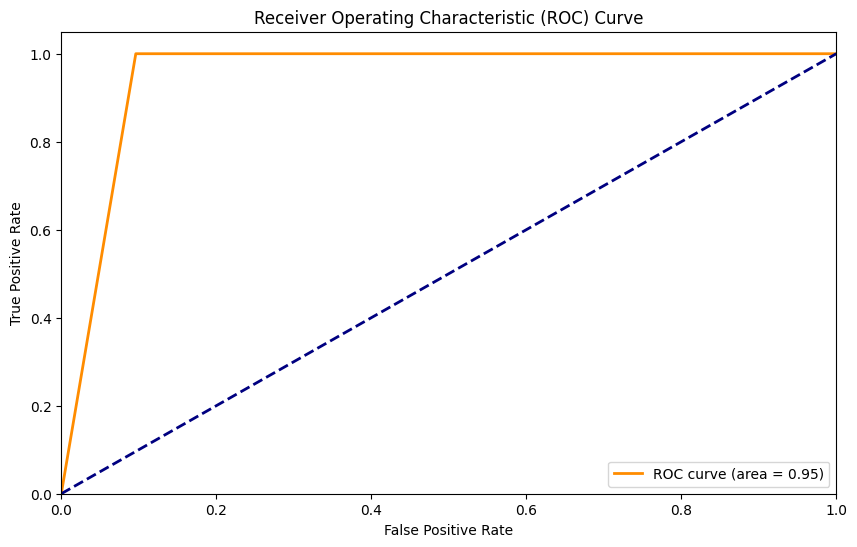

In [50]:
make_roc_auc_curve(test_labels,test_predictions)

In [51]:

# Define function to plot training & Validation Metrics

def plot_training_metrics(history):
    """
    Plot training metrics and loss from a model's training history.

    Parameters:
    - history (History): The training history of a model containing metrics and loss information.

    Returns:
    None
    """
    # Extract metrics from history
    acc = history.history['accuracy']
    precision = history.history['precision']
    recall = history.history['recall']
    auc_roc = history.history['auc_roc']
    auc_pr = history.history['auc_pr']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
       # Set a larger figure size
    plt.figure(figsize=(10, 10))


    # Plot accuracy metrics
    plt.subplot(3, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, precision, label='Training Precision')
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, auc_roc, label='Training AUC ROC')
    plt.plot(epochs_range, auc_pr, label='Training AUC PR')
    plt.legend(loc='lower right')
    plt.title('Training Metrics')

    # Plot loss metrics
    plt.subplot(3, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()


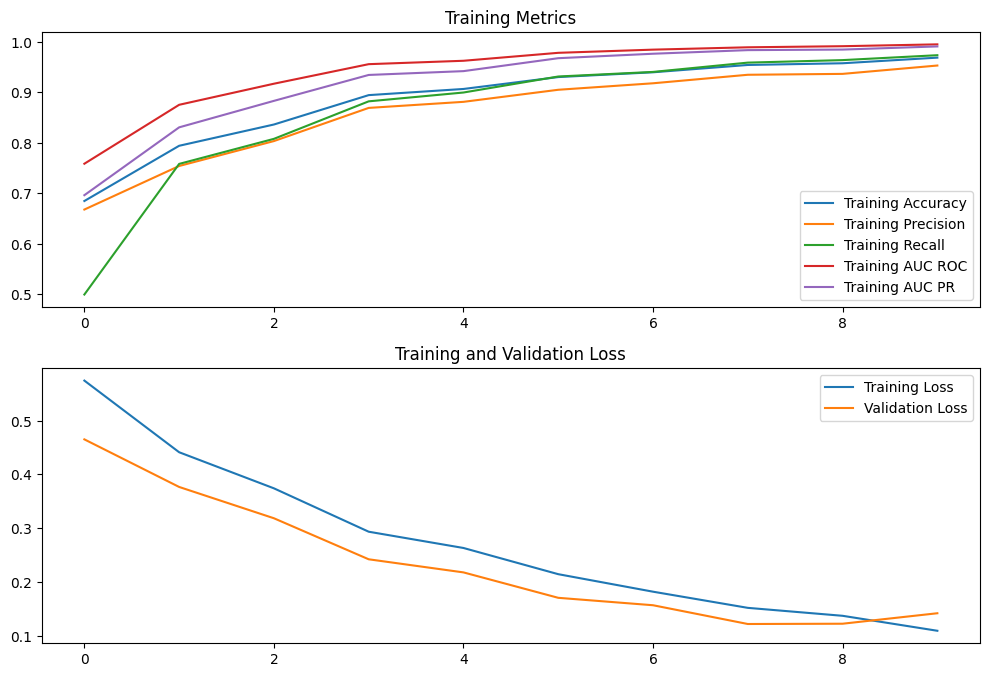

In [52]:
plot_training_metrics(history)

In [53]:

def apply_weight_clustering(model, num_of_clusters, clustering_learning_rate):
    """
    Apply weight clustering to the given model.

    Parameters:
    - model (tf.keras.Model): The input model to be clustered.
    - num_of_clusters (int): The number of clusters to use for weight clustering.
    - clustering_learning_rate (float): The learning rate for fine-tuning the clustered model.

    Returns:
    - tf.keras.Model: The clustered model.
    """

    # Import required modules from TensorFlow Model Optimization
    cluster_weights = tfmot.clustering.keras.cluster_weights
    CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

    # Set clustering parameters
    clustering_params = {
        'number_of_clusters': num_of_clusters,
        'cluster_centroids_init': CentroidInitialization.LINEAR
    }

    # Cluster the whole model
    clustered_model = cluster_weights(model, **clustering_params)

    # Use a smaller learning rate for fine-tuning the clustered model
    opt = tf.keras.optimizers.Adam(learning_rate=clustering_learning_rate)

    # Compile the clustered model with specified metrics
    clustered_model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc_roc'),
            AUC(name='auc_pr', curve='PR')
        ]
    )

    # Display a summary of the clustered model
    clustered_model.summary()

    return clustered_model


In [54]:
# Apply weight clustering for model
num_of_clusters=16
clustering_learning_rate=1e-5

clustered_model = apply_weight_clustering(model,num_of_clusters,clustering_learning_rate)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_conv2d (ClusterWei  (None, 300, 300, 16)      320       
 ghts)                                                           
                                                                 
 cluster_max_pooling2d (Clu  (None, 150, 150, 16)      0         
 sterWeights)                                                    
                                                                 
 cluster_conv2d_1 (ClusterW  (None, 150, 150, 32)      9264      
 eights)                                                         
                                                                 
 cluster_max_pooling2d_1 (C  (None, 75, 75, 32)        0         
 lusterWeights)                                                  
                                                                 
 cluster_conv2d_2 (ClusterW  (None, 75, 75, 64)        3

In [55]:
# Fine-tune model
clustered_model.fit(
grayscale_train_data,
  steps_per_epoch=steps_per_epoch*2,
  epochs=1,
  validation_data =grayscale_validation_data,validation_steps=validation_steps*2)

298/298 [==============================] - 67s 197ms/step - loss: 0.0877 - accuracy: 0.9796 - precision: 0.9688 - recall: 0.9833 - auc_roc: 0.9962 - auc_pr: 0.9931 - val_loss: 0.0902 - val_accuracy: 0.9794 - val_precision: 0.9725 - val_recall: 0.9788 - val_auc_roc: 0.9958 - val_auc_pr: 0.9905


In [61]:
def evaluate_models(baseline_model, clustered_model, validation_data, validation_steps):
    """
    Evaluate baseline and clustered models on validation data.

    Parameters:
    - baseline_model: The baseline model to be evaluated.
    - clustered_model: The clustered model to be evaluated.
    - validation_data: The validation data to be used for evaluation.
    - validation_steps: The number of steps per epoch in the validation data generator.

    Returns:
    - tuple: A tuple containing the evaluation metrics for the baseline model and the clustered model.
    """
    # Evaluate the baseline model
    baseline_model_metrics = baseline_model.evaluate(validation_data, steps=validation_steps)

    # Evaluate the clustered model
    clustered_model_metrics = clustered_model.evaluate(validation_data, steps=validation_steps)

    baseline_metrics = {
    'Loss': baseline_model_metrics[0],
    'Accuracy': baseline_model_metrics[1],
    'Precision': baseline_model_metrics[2],
    'Recall': baseline_model_metrics[3],
    'AUC ROC': baseline_model_metrics[4],
    'AUC PR': baseline_model_metrics[5]
}

    clustered_metrics = {
        'Loss': clustered_model_metrics[0],
        'Accuracy': clustered_model_metrics[1],
        'Precision': clustered_model_metrics[2],
        'Recall': clustered_model_metrics[3],
        'AUC ROC': clustered_model_metrics[4],
        'AUC PR': clustered_model_metrics[5]
    }


    return baseline_metrics, clustered_metrics



In [62]:
# Evaluate models
baseline_metrics, clustered_metrics = evaluate_models(model, clustered_model, grayscale_validation_data, validation_steps)


64/64 [==============================] - 8s 128ms/step - loss: 0.0927 - accuracy: 0.9787 - precision: 0.9729 - recall: 0.9764 - auc_roc: 0.9953 - auc_pr: 0.9877


In [63]:
# Print baseline model metrics
print("Baseline Model Metrics:")
for metric_name, metric_value in baseline_metrics.items():
    print(f"{metric_name}: {metric_value}")

# Print clustered model metrics
print("\nClustered Model Metrics:")
for metric_name, metric_value in clustered_metrics.items():
    print(f"{metric_name}: {metric_value}")

Baseline Model Metrics:
Loss: 0.15612566471099854
Accuracy: 0.9534192085266113
Precision: 0.9894737005233765
Recall: 0.89737468957901
AUC ROC: 0.9953076243400574
AUC PR: 0.9853657484054565

Clustered Model Metrics:
Loss: 0.09274677187204361
Accuracy: 0.9786917567253113
Precision: 0.9729411602020264
Recall: 0.9763872623443604
AUC ROC: 0.9953228235244751
AUC PR: 0.9877128601074219


In [64]:
predicted_clustered = make_predictions(clustered_model,grayscale_test_data,num_test_samples)

368/368 [==============================] - 8s 21ms/step


In [65]:
make_confusion_matrix(test_labels,predicted_clustered)

array([[203,   5],
       [  5, 155]])

In [66]:
make_classification_report(test_labels,predicted_clustered,class_names)

              precision    recall  f1-score   support

   def_front       0.98      0.98      0.98       208
    ok_front       0.97      0.97      0.97       160

    accuracy                           0.97       368
   macro avg       0.97      0.97      0.97       368
weighted avg       0.97      0.97      0.97       368



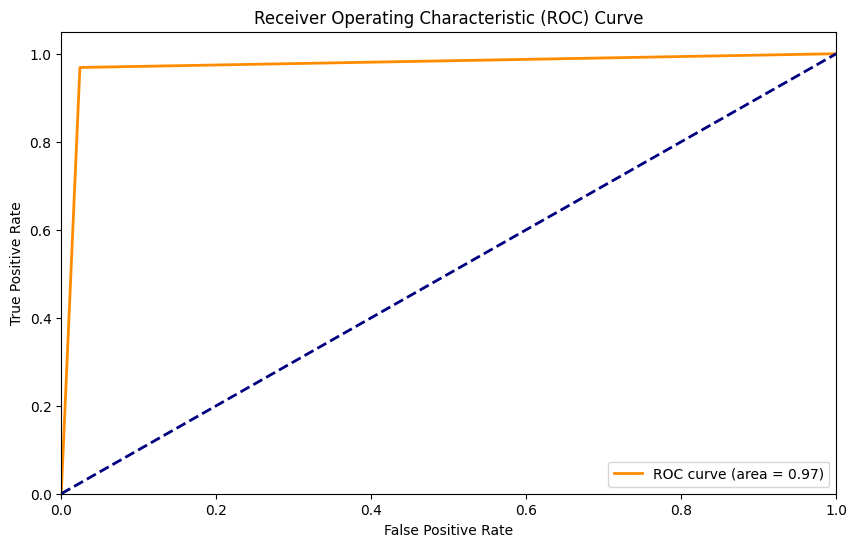

In [67]:
make_roc_auc_curve(test_labels,predicted_clustered)

In [68]:
# Prepare model for serving by removing training-only variables.
model_for_serving = tfmot.clustering.keras.strip_clustering(clustered_model)

model_for_serving.save('model_serving.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
